# US Bike Share Activity Snapshot in 2016

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

In [1]:
import csv
from datetime import datetime 
from pprint import pprint 

In [104]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        
        trip_reader = csv.DictReader(f_in)
        first_trip = next(trip_reader)
        pprint(first_trip)
        
    return (city, first_trip)

data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.

In [105]:
def duration_in_mins(datum, city):

    if city == 'Washington':
        duration = float(datum['Duration (ms)'])/60000
    else:
        duration = float(datum['tripduration'])/60
    
    return duration

tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [106]:
def time_of_trip(datum, city):
    
    if city == 'Washington': 
        dateset = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M') 
        day_of_week = dateset.strftime('%A') 
           
    elif city == 'NYC':
        dateset = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
        day_of_week = dateset.strftime('%A')
    
    else: 
        dateset = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M') 
        day_of_week = dateset.strftime('%A')
        
    return (dateset.month, dateset.hour, day_of_week)


tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [107]:
def type_of_user(datum, city):
   
    if city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
    else: 
        user_type = datum['usertype']
        
    return user_type


tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

In [108]:
def condense_data(in_file, out_file, city):

    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
       
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        trip_reader = csv.DictReader(f_in)

        for row in trip_reader:
          
            new_point = {}

            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)
            new_point['hour'] = time_of_trip(row, city)
            new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)

            trip_writer.writerow({'duration':new_point['duration'],
                            'month': new_point['month'][0],
                            'hour': new_point['hour'][1],
                            'day_of_week': new_point['day_of_week'][2],
                            'user_type': new_point['user_type']})

In [109]:
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

In [110]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        
        reader = csv.DictReader(f_in)
       
        n_subscribers = 0
        n_customers = 0
   
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        n_total = n_subscribers + n_customers
        s_proportion = (n_subscribers / n_total)*100
        c_proportion = (n_customers / n_total)*100
        
        return(n_subscribers, n_customers, n_total, s_proportion, c_proportion)

In [111]:
data_file = {'Washington': './data/Washington-2016-Summary.csv', 
             'chicago': './data/Chicago-2016-Summary.csv', 
             'NYC': './data/NYC-2016-Summary.csv'}

for city in data_file:
    print(city, number_of_trips(data_file[city]))

Washington (51753, 14573, 66326, 78.0282242257938, 21.971775774206193)
chicago (54982, 17149, 72131, 76.22520136973007, 23.774798630269924)
NYC (245896, 30902, 276798, 88.83590199351151, 11.164098006488485)


In [112]:
def avg_trip_length(filename):
   
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        durations = []
        for row in reader:
            durations.append(float(row['duration']))
        avg_duration = sum(durations)/len(durations)
        
        n = 0
        for i in durations:
            if i > 30:
                n += 1
              
        over_30 = (n/len(durations))*100
            
        return avg_duration, over_30

In [113]:
data_file = {'Washington': './data/Washington-2016-Summary.csv', 
             'chicago': './data/Chicago-2016-Summary.csv', 
             'NYC': './data/NYC-2016-Summary.csv',
             'sample': './examples/BayArea-Y3-Summary.csv'}

for city in data_file:
    print(city, avg_trip_length(data_file[city]))

Washington (18.93287355913721, 10.83888671109369)
chicago (16.563629368787335, 8.332062497400562)
NYC (15.81259299802294, 7.3024371563378345)
sample (14.038656929671422, 3.5243689474519764)


In [114]:
def average_duration(filename):
   
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        
        s_list = []
        c_list = []
        for row in reader:
            if row['user_type'] == 'Subscriber':

                    s_list.append(float(row['duration']))
                    s_duration = sum(s_list)/len(s_list)
            else:
                    c_list.append(float(row['duration']))
                    c_duration = sum(c_list)/len(c_list)

            
        return s_duration, c_duration

In [115]:
data_file = {'Washington': './data/Washington-2016-Summary.csv', 
             'chicago': './data/Chicago-2016-Summary.csv', 
             'NYC': './data/NYC-2016-Summary.csv',
             'sample': './examples/BayArea-Y3-Summary.csv'}

for city in data_file:
    print(city, average_duration(data_file[city]))

Washington (12.528120499294745, 41.67803139252976)
chicago (12.067201690250076, 30.979781133982506)
NYC (13.680790523907177, 32.77595139473187)
sample (9.512633839275217, 54.55121116377032)


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

In [117]:
import matplotlib.pyplot as plt

%matplotlib inline 

def trip_times(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        trip_list = []
        
        for row in reader:
            trip_list.append(float(row['duration']))
        return trip_list

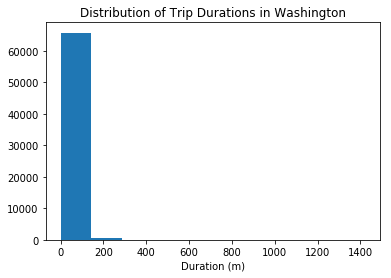

In [118]:
data_file = ['./data/Washington-2016-Summary.csv']
for d in data_file:
    plt.hist(trip_times(d))
    plt.title('Distribution of Trip Durations in Washington')
    plt.xlabel('Duration (m)')
    plt.show() 

In [119]:
def s_trip_times(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        s_trip_list = []
        
        for row in reader:
            if row['user_type']=='Subscriber':
                s_trip_list.append(float(row['duration']))
        
        return s_trip_list

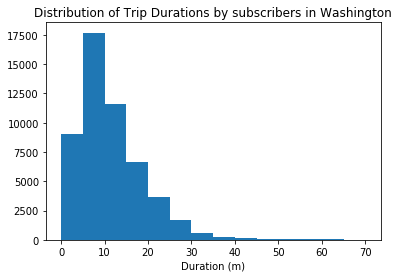

In [120]:
data_file = ['./data/Washington-2016-Summary.csv']
for d in data_file:
    plt.hist(s_trip_times(d), bins = range(0, 75, 5))
    #plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
    plt.title('Distribution of Trip Durations by subscribers in Washington')
    plt.xlabel('Duration (m)')
    plt.show() 

In [121]:
def c_trip_times(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        c_trip_list = []
        
        for row in reader:
            if row['user_type']=='Customer':
                c_trip_list.append(float(row['duration']))
        
        return c_trip_list

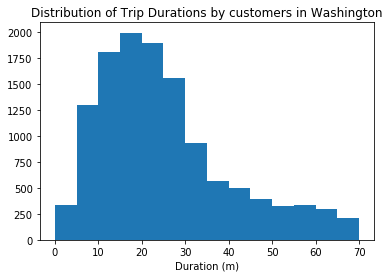

In [122]:
data_file = ['./data/Washington-2016-Summary.csv']

for d in data_file:
    plt.hist(c_trip_times(d), bins = range(0, 75, 5))
    #plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))
    plt.title('Distribution of Trip Durations by customers in Washington')
    plt.xlabel('Duration (m)')
    plt.show() 

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. 

In [123]:
def s_day_of_trips(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
    
        weekday = []
        weekend = []
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                if row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday':
                    weekend.append(float(row['duration']))
                else:
                    weekday.append(float(row['duration']))
                    
        return (sum(weekday)/5, sum(weekend)/2)
        
def c_day_of_trips(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
    
        weekday = []
        weekend = []
        
        for row in reader:
            if row['user_type'] == 'Customer':
                if row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday':
                    weekend.append(float(row['duration']))
                else:
                    weekday.append(float(row['duration']))
                    
        return (sum(weekday)/5, sum(weekend)/2)

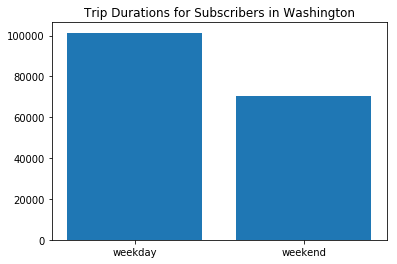

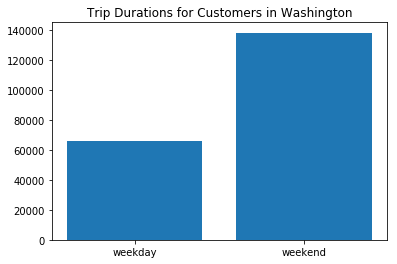

In [124]:
data_file = ['./data/Washington-2016-Summary.csv']

for d in data_file:
    data = s_day_of_trips(d)
    labels = ['weekday', 'weekend']
    plt.bar(range(len(data)), data) 
    plt.xticks(range(len(data)), labels)
    plt.title('Trip Durations for Subscribers in Washington')
    plt.show()
    
for d in data_file:
    data = c_day_of_trips(d)
    labels = ['weekday', 'weekend']
    plt.bar(range(len(data)), data)
    plt.xticks(range(len(data)), labels)
    plt.title('Trip Durations for Customers in Washington')
    plt.show()

<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions.

In [102]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0